In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.chdir('C:/Users/nurib/PythonCodes/Mammogram-segmentation-main_v10')

In [3]:
from modelVit import *
from data import *

vid="v023_5" #version id should match the file number 

Model: "Improved_ViT_Segmentation_3Classes"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 240, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 vi_t_encoder (ViTEncoder)      (None, 450, 64)      178112      ['input_1[0][0]']                
                                                                 

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

#Data augmentation
data_gen_args = dict(width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='wrap')

# SETTINGS ***
batch_size=1
learning_rate=1e-4

train_gen = trainGenerator(batch_size,'fgt_seg07/train0'+vid[-1],'fgt_seg','fgt_seg_labels',data_gen_args,save_to_dir = None,target_size=(480, 240))
valid_gen = trainGenerator(batch_size,'fgt_seg07/valid0'+vid[-1],'fgt_seg','fgt_seg_labels',data_gen_args,save_to_dir = None,target_size=(480, 240))

# 48 images are used for training, 12 images for validating and 6 images for testing
train_steps = 48//batch_size
valid_steps = 12//batch_size

In [5]:
# 48 images are used for training, 12 images for validating and 6 images for testing
#train_steps = 48//batch_size
#valid_steps = 12//batch_size

# SETTINGS ***
loss = combined_loss #updated_tversky_loss#tversky_loss
steps_per_epoch=3*train_steps
num_epochs=100     
dropout_rate=0.5

model = build_improved_vit_segmentation()

In [ ]:
# Mevcut modelin çıkış katmanını al
x = model.output  # Son katman

# Eğer çıktı (240, 120) gibi küçükse, 2x büyüt (480x240 yap)
x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)

# 4 kanallı Conv2D ekleyerek çıktıyı 4 kanal yap
x = Conv2D(4, (1, 1), activation="softmax")(x)

# Yeni model oluştur
model = Model(inputs=model.input, outputs=x)

# Yeni modeli kontrol et
model.summary()

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate)
metrics = ["acc", dice_coef, iou]
#metrics=[dice_coef, iou, precision, recall, f1_score]
model.compile(loss=loss, optimizer=opt, metrics=metrics)

In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks = [
             ModelCheckpoint('files/unet_fgt_seg_'+vid+'.hdf5', verbose=1, save_best_model=True),
             #ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1, min_lr=1e-8),
             ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.5, verbose=1, min_lr=1e-7),
             CSVLogger("files/data_"+vid+".csv"),
             #EarlyStopping(monitor="val_loss", patience=10, verbose=1)
             EarlyStopping(monitor="val_loss", patience=20, verbose=1)
            ]

def cosine_annealing(epoch, lr):
    lr_min = 1e-6
    lr_max = 1e-3
    return lr_min + (lr_max - lr_min) * (1 + np.cos(np.pi * epoch / num_epochs)) / 2

lr_callback = LearningRateScheduler(cosine_annealing)

In [7]:
model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=steps_per_epoch, validation_steps=valid_steps, epochs=num_epochs, callbacks=[lr_callback] + callbacks)

Found 48 images belonging to 1 classes.
Found 48 images belonging to 1 classes.
Epoch 1/100
Found 12 images belonging to 1 classes.] - ETA: 0s - loss: 0.1733 - acc: 0.7806 - dice_coef: 0.7232 - iou: 0.5827   
Found 12 images belonging to 1 classes.

Epoch 1: saving model to files\unet_fgt_seg_v023_5.hdf5
144/144 [==============================] - 11s 33ms/step - loss: 0.1727 - acc: 0.7812 - dice_coef: 0.7241 - iou: 0.5838 - val_loss: 0.1088 - val_acc: 0.8567 - val_dice_coef: 0.8477 - val_iou: 0.7375 - lr: 0.0010
Epoch 2/100
143/144 [============================>.] - ETA: 0s - loss: 0.1168 - acc: 0.8397 - dice_coef: 0.8200 - iou: 0.6981
Epoch 2: saving model to files\unet_fgt_seg_v023_5.hdf5
144/144 [==============================] - 4s 28ms/step - loss: 0.1165 - acc: 0.8400 - dice_coef: 0.8202 - iou: 0.6985 - val_loss: 0.0915 - val_acc: 0.8915 - val_dice_coef: 0.8600 - val_iou: 0.7560 - lr: 9.9975e-04
Epoch 3/100
143/144 [============================>.] - ETA: 0s - loss: 0.1073 - acc: 

In [7]:
model.load_weights("files/unet_fgt_seg_"+vid+".hdf5")

In [8]:
validGene = testGenerator("segmentation_data/test/fgt_seg")

In [9]:
results = model.predict(validGene,steps=6,verbose=1)

6/6 [==============================] - 4s 40ms/step


In [11]:
saveResult("segmentation_data/test/fgt_seg",results,vid[:4])

In [10]:
print("Results shape:", results.shape)
for i in range(len(results)):
    print(f"results[{i}].shape:", results[i].shape)


Results shape: (6, 480, 240, 3)
results[0].shape: (480, 240, 3)
results[1].shape: (480, 240, 3)
results[2].shape: (480, 240, 3)
results[3].shape: (480, 240, 3)
results[4].shape: (480, 240, 3)
results[5].shape: (480, 240, 3)


In [11]:
import os
import numpy as np
import cv2
from sklearn.metrics import f1_score, jaccard_score


mask_dir = "segmentation_data/test/fgt_seg_labels"
mask_files = [
    "A_0040_1.RIGHT_MLO_LI.png",
    "A_0096_1.RIGHT_MLO_LI.png",
    "B_3627_1.RIGHT_MLO_LI.png",
    "B_3680_1.RIGHT_MLO_LI.png",
    "D_4574_1.RIGHT_MLO_LI.png",
    "D_4588_1.RIGHT_MLO_LI.png"
]

y_true = []
y_pred = []

for i, mask_file in enumerate(mask_files):
    
    gt_path = os.path.join(mask_dir, mask_file)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (240, 480))

    
    gt_class = np.zeros_like(gt_mask, dtype=np.uint8)
    gt_class[gt_mask == 255] = 0   # background
    gt_class[(gt_mask == 128) | (gt_mask == 192)] = 1  # adipose
    gt_class[gt_mask == 64] = 2    # pectoral

    
    pred_class = np.argmax(results[i], axis=-1).astype(np.uint8)

 
    y_true.append(gt_class.flatten())
    y_pred.append(pred_class.flatten())


y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)


print("F1 (Dice) per class:", f1_score(y_true, y_pred, average=None))
print("IoU per class:", jaccard_score(y_true, y_pred, average=None))
print("Macro F1 (Dice):", f1_score(y_true, y_pred, average='macro'))
print("Macro IoU:", jaccard_score(y_true, y_pred, average='macro'))




F1 (Dice) per class: [0.87024461 0.95254592 0.97741979]
IoU per class: [0.77029472 0.90939158 0.95583679]
Macro F1 (Dice): 0.9334034403361269
Macro IoU: 0.8785076975665885


In [12]:
import os
import numpy as np
import cv2


def dice_coef_np(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_np(y_true, y_pred):
    smooth = 1e-6  
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    
    return (intersection + smooth) / (union + smooth)


mask_dir = "segmentation_data/test/fgt_seg_labels"
mask_files = [
    "A_0040_1.RIGHT_MLO_LI.png",
    "A_0096_1.RIGHT_MLO_LI.png",
    "B_3627_1.RIGHT_MLO_LI.png",
    "B_3680_1.RIGHT_MLO_LI.png",
    "D_4574_1.RIGHT_MLO_LI.png",
    "D_4588_1.RIGHT_MLO_LI.png"
]

num_classes = 3  
dice_scores = [[] for _ in range(num_classes)]
iou_scores = [[] for _ in range(num_classes)]

for i, mask_file in enumerate(mask_files):
    
    gt_path = os.path.join(mask_dir, mask_file)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (240, 480))

    
    gt_class = np.zeros_like(gt_mask, dtype=np.uint8)
    gt_class[gt_mask == 255] = 0   # Background
    gt_class[(gt_mask == 128) | (gt_mask == 192)] = 1  # Adipose (192 = fibroglandular dahil burada)
    gt_class[gt_mask == 64] = 2    # Pectoral

    
    pred_class = np.argmax(results[i], axis=-1).astype(np.uint8)

    
    for c in range(num_classes):
        gt_binary = (gt_class == c).astype(np.float32)
        pred_binary = (pred_class == c).astype(np.float32)

        dice = dice_coef_np(gt_binary, pred_binary)
        iou = iou_np(gt_binary, pred_binary)

        dice_scores[c].append(dice)
        iou_scores[c].append(iou)


class_names = ['Background', 'Adipose', 'Pectoral']
for c in range(num_classes):
    print(f"{class_names[c]} - Dice: {np.mean(dice_scores[c]):.4f}, IoU: {np.mean(iou_scores[c]):.4f}")


macro_dice = np.mean([np.mean(s) for s in dice_scores])
macro_iou = np.mean([np.mean(s) for s in iou_scores])

print(f"\nMacro Dice: {macro_dice:.4f}")
print(f"Macro IoU: {macro_iou:.4f}")


Background - Dice: 0.8265, IoU: 0.7218
Adipose - Dice: 0.9492, IoU: 0.9052
Pectoral - Dice: 0.9745, IoU: 0.9518

Macro Dice: 0.9168
Macro IoU: 0.8596


Sütunlar: Index(['epoch', 'acc', 'dice_coef', 'iou', 'loss', 'lr', 'val_acc',
       'val_dice_coef', 'val_iou', 'val_loss'],
      dtype='object')


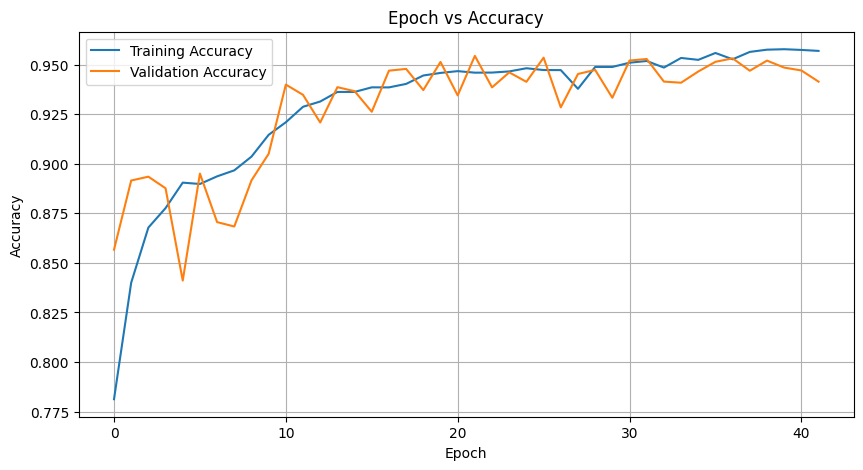

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


csv_path = r"C:\Users\nurib\PythonCodes\Mammogram-segmentation-main_v10\files\data_v023_5.csv"


df = pd.read_csv(csv_path)


print("Sütunlar:", df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["acc"], label="Training Accuracy")
plt.plot(df["epoch"], df["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid(True)
plt.show()



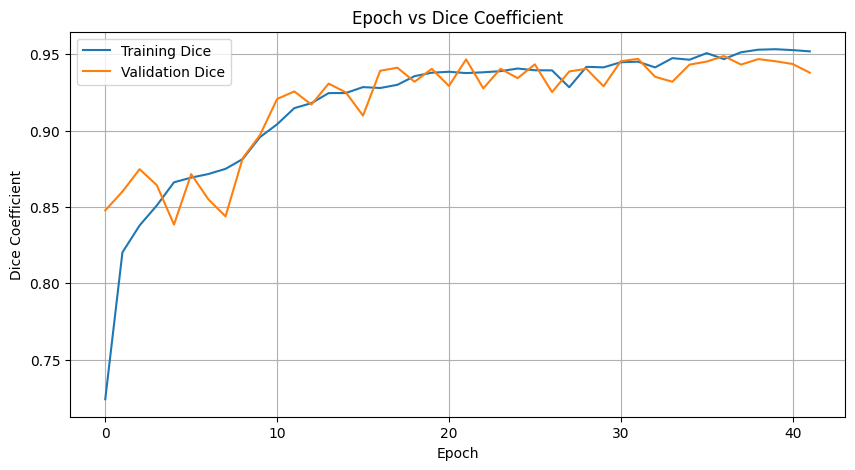

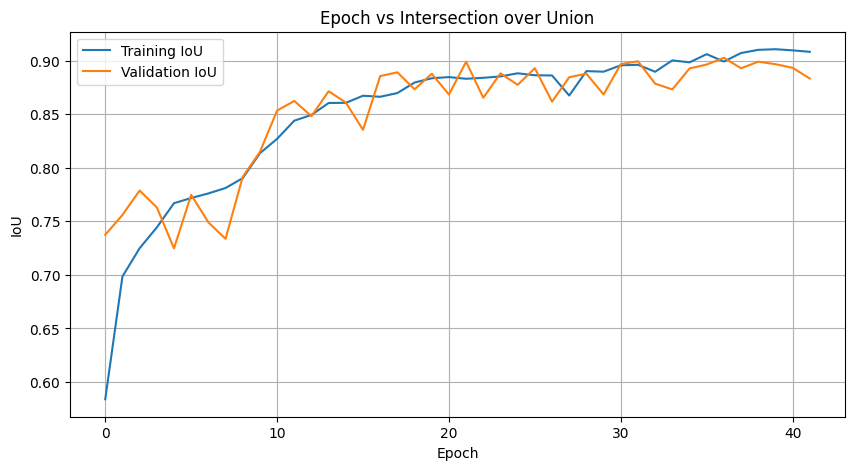

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["dice_coef"], label="Training Dice")
plt.plot(df["epoch"], df["val_dice_coef"], label="Validation Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Epoch vs Dice Coefficient")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["iou"], label="Training IoU")
plt.plot(df["epoch"], df["val_iou"], label="Validation IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Epoch vs Intersection over Union")
plt.legend()
plt.grid(True)
plt.show()